<a href="https://colab.research.google.com/github/ShawnFromChineseTaipei/class_test/blob/main/Transportation_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Transportation.csv')

In [3]:
df.dropna(inplace = True)
print(df.shape)

(1324311, 44)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1324311 entries, 0 to 1707204
Data columns (total 43 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1324311 non-null  int64  
 1   Start_Time             1324311 non-null  object 
 2   End_Time               1324311 non-null  object 
 3   Start_Lat              1324311 non-null  float64
 4   Start_Lng              1324311 non-null  float64
 5   End_Lat                1324311 non-null  float64
 6   End_Lng                1324311 non-null  float64
 7   Distance(mi)           1324311 non-null  float64
 8   City                   1324311 non-null  object 
 9   County                 1324311 non-null  object 
 10  State                  1324311 non-null  object 
 11  Zipcode                1324311 non-null  object 
 12  Country                1324311 non-null  object 
 13  Timezone               1324311 non-null  object 
 14  Airport_Code      

In [7]:
#首先將類別型資料以及布林值分類，便於分析
categorical_columns = df.select_dtypes(include=['object','bool']).columns
categorical_columns

Index(['Start_Time', 'End_Time', 'City', 'County', 'State', 'Zipcode',
       'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Wind_Direction', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [8]:
#在針對這些非數值型資料做一次LabelEncoder
from sklearn import preprocessing

for i in categorical_columns:
    en = preprocessing.LabelEncoder()
    df[i]= en.fit_transform(df[i])

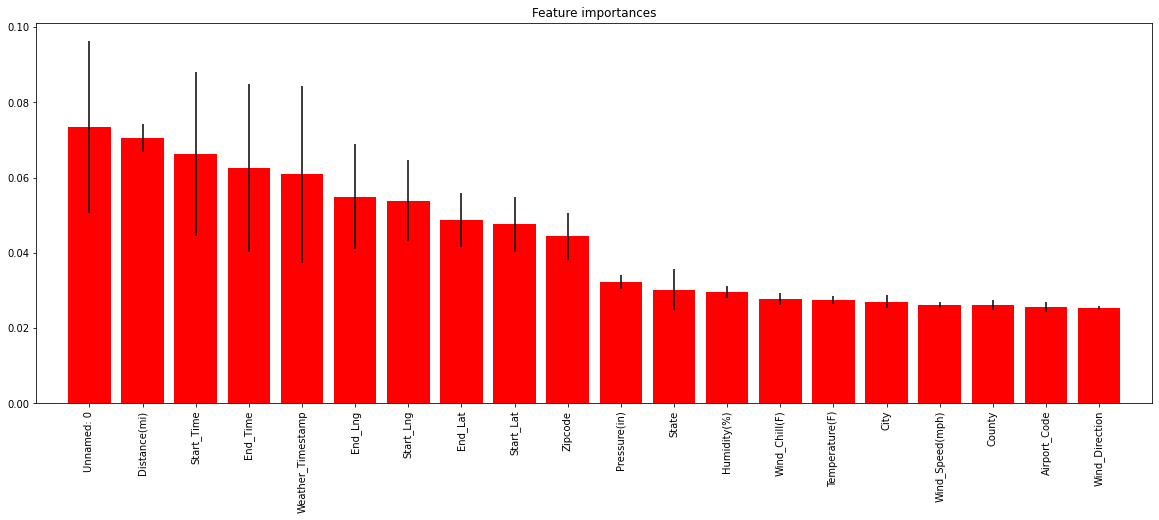

In [9]:
train_y = df['Severity'].values
x_cols = [col for col in df.columns if col not in ['Severity'] if df[col].dtype=='float64'or df[col].dtype=='int64']
train_col= df[x_cols]

fearture_name = train_col.columns.values 

from sklearn import ensemble 

model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(train_col,train_y)


importance = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)
indices = np.argsort(importance)[::-1][:20]

plt.figure(figsize=(20,7))
plt.title("Feature importances")
plt.bar(range(len(indices)), importance[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), fearture_name[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

In [10]:
y = df['Severity'].copy()
X = df.drop('Severity', axis=1).copy()

In [11]:
y.unique()
y = y-1

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=100)

In [13]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [14]:
inputs = tf.keras.Input(shape=(X.shape[1],))
x = tf.keras.layers.Dense(64, activation='relu')(inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

batch_size = 40
epochs = 100

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
21189/21189 [==============================] - 66s 3ms/step - loss: 0.1909 - accuracy: 0.9401 - val_loss: 0.1763 - val_accuracy: 0.9422 - lr: 0.0010
Epoch 2/100
21189/21189 [==============================] - 62s 3ms/step - loss: 0.1748 - accuracy: 0.9427 - val_loss: 0.1730 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 3/100
21189/21189 [==============================] - 52s 2ms/step - loss: 0.1715 - accuracy: 0.9433 - val_loss: 0.1722 - val_accuracy: 0.9427 - lr: 0.0010
Epoch 4/100
21189/21189 [==============================] - 58s 3ms/step - loss: 0.1692 - accuracy: 0.9439 - val_loss: 0.1686 - val_accuracy: 0.9437 - lr: 0.0010
Epoch 5/100
21189/21189 [==============================] - 56s 3ms/step - loss: 0.1678 - accuracy: 0.9442 - val_loss: 0.1675 - val_accuracy: 0.9439 - lr: 0.0010
Epoch 6/100
21189/21189 [==============================] - 60s 3ms/step - loss: 0.1666 - accuracy: 0.9445 - val_loss: 0.1665 - val_accuracy: 0.9442 - lr: 0.0010
Epoch 7/100
21189/21189 [=========

In [15]:
print("Test Accuracy:", model.evaluate(X_test, y_test, verbose=0)[1])

Test Accuracy: 0.9450017809867859
